## EXTRAÇAO DOS DADOS DO SATELITE  - LANDSAT - NASA
Esse é o notebook que vai servir para formar a variável Target para meu dataset a partir da criacao de GeoTiffs com a banda Térmica de Temperatura de Superfície

In [ ]:
# Warnings 
import warnings
warnings.filterwarnings('ignore')

# Importando as bibliotecas necessárias
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import jet,RdYlGn


import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

### Aqui eu defini as areas que iria extrair para montar meu dataset
O mesmo processo foi repetido para todos os recortes a seguir

In [2]:
# Recorte 1
#lower_left  = (-23.05, -43.50)  # latitude, longitude
#upper_right = (-22.80, -43.15)

# Recorte 2 – Zona Norte / Maracanã a Del Castilho
#lower_left  = (-22.96, -43.35)
#upper_right = (-22.80, -43.10)

# Recorte 3 – Barra da Tijuca e Recreio
#lower_left  = (-23.03, -43.42)
#upper_right = (-22.85, -43.17)

#Recorte 4 – Centro + Zona Portuária
#lower_left  = (-22.94, -43.25)
#upper_right = (-22.80, -43.00)

# Recorte 5 – Ilha do Governador / Fundão / Aeroporto Galeão
#lower_left  = (-22.90, -43.30)
#upper_right = (-22.75, -43.05)

# Recorte 6 – Jacarepaguá e Taquara
lower_left  = (-23.00, -43.45)
upper_right = (-22.85, -43.20)

# Recorte 7 – Zona Oeste (Campo Grande, Bangu)
#lower_left  = (-23.03, -43.60)
#upper_right = (-22.85, -43.35)

# Recorte 8 – Região de Niterói
#lower_left  = (-22.95, -43.15)
#upper_right = (-22.80, -42.90)

#Recorte 9 – Guaratiba e Itaguai
#lower_left  = (-23.10, -43.80)
#upper_right = (-22.95, -43.55)


In [ ]:
# Calcular os limites para realizar uma busca de dados do arquivo
# bounds = (min_lon, min_lat, max_lon, max_lat)

bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [ ]:
# Intervalo de tempo para busca de dados
# Usaremos um período de 3 meses para buscar dados
time_window = "2024-01-01/2024-06-01"

Usando o pystac_client, podemos buscar no endpoint STAC do Planetary Computer por itens que correspondam aos parâmetros da nossa consulta. A pesquisa procura por cenas de "nuvens baixas" com cobertura de nuvens inferior a 30%. Também vamos limitar nossa pesquisa para o Landsat-8 para evitar a falha do corretor de linha de varredura do Landsat-7. O resultado é o número de cenas que atendem aos critérios da nossa pesquisa e que tocam nossa área de interesse. Algumas dessas cenas podem ser parciais ou conter nuvens.

In [5]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 30},"platform": {"in": ["landsat-8"]}},
)

In [ ]:
items = list(search.get_items())
print('Numeros de cenas nessa regiao comm essas condicoes nesse periodo:',len(items))

This is the number of scenes that touch our region: 3


 Em seguida, vamos carregar os dados em um DataArray [xarray](https://xarray.pydata.org/en/stable/) usando [stackstac](https://stackstac.readthedocs.io/).
 Vamos manter apenas as bandas espectrais comumente usadas (Vermelho, Verde, Azul, NIR, Temperatura da Superfície).
 Existem também várias outras <b>configurações importantes para os dados</b>: Alteramos a projeção para epsg=4326, que é o padrão de latitude-longitude em graus.
Especificamos a resolução espacial de cada pixel para ser de 30 metros.


In [7]:
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

In [ ]:
# Define a resolução do pixel para o produto final
# Define a escala de acordo com o nosso CRS selecionado, portanto, usaremos o grau

resolution = 30  # metros por pixel
scale = resolution / 111320.0 # graus por pixel para crs=4326

## Resumo das Bandas do Landsat
 A seguinte lista de bandas será carregada pelo comando STAC do Open Data Cube (ODC):
 Usaremos dois comandos de carregamento para separar os dados RGB dos dados de Temperatura da Superfície.

 Band 2 = azul = 30m
 Band 3 = verde = 30m
 Band 4 = vermelho = 30m
 Band 5 = nir08 (infravermelho próximo) = 30m
 Band 11 = Temperatura da Superfície = lwir11 = 100m






In [9]:
data1 = stac_load(
    items,
    bands=["red", "green", "blue", "nir08"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

In [ ]:
data2 = stac_load(
    items,
    bands=["lwir11"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Graus
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

 Como os dados que correspondem à nossa consulta não são muito grandes, podemos persistir isso na memória distribuída.
 Uma vez na memória, as operações subsequentes serão muito mais rápidas.


In [11]:

data2 = data2.persist()

### Escalonamento de Conjuntos de Dados
 Os produtos Landsat Collection-2 Level-2 exigem escalonamento antes de criar produtos de saída válidos. 
Os fatores de escala para as bandas RGB e NIR diferem dos fatores de escala para a banda de Temperatura da Superfície.


In [ ]:
# Fatores de Escala para as bandas RGB e NIR

scale1 = 0.0000275 
offset1 = -0.2 
data1 = data1.astype(float) * scale1 + offset1

In [ ]:
# Fatores de Escala para a banda de Temperatura da Superfície

scale2 = 0.00341802
offset2 = 149.0
kelvin_celsius = 273.15 # converter de Kelvin para Celsius
data2 = data2.astype(float) * scale2 + offset2 - kelvin_celsius

### Visualizando imagens RGB (cor real) da série temporal



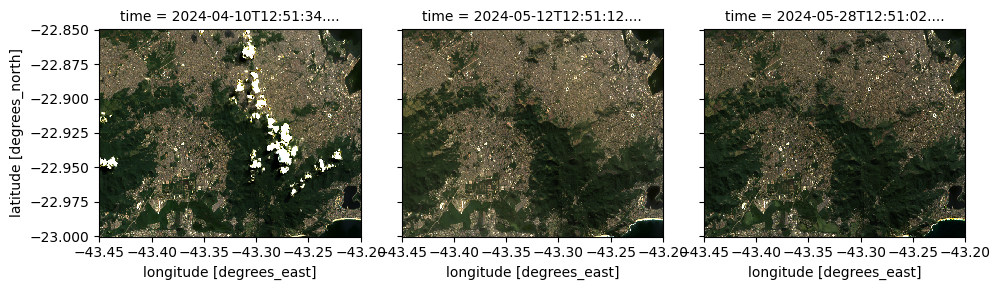

In [14]:
plot_data = data1[["red","green","blue"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

### Produtos de Saída

Escolheremos a melhor cena (sem nuvens, sem dados ausentes) para construir nossos produtos de saída.
 Isso não exigirá cálculos de filtragem mediana, pois vamos selecionar apenas uma data da série temporal.



In [ ]:
# Escolhendo a cena 0
scene = 0

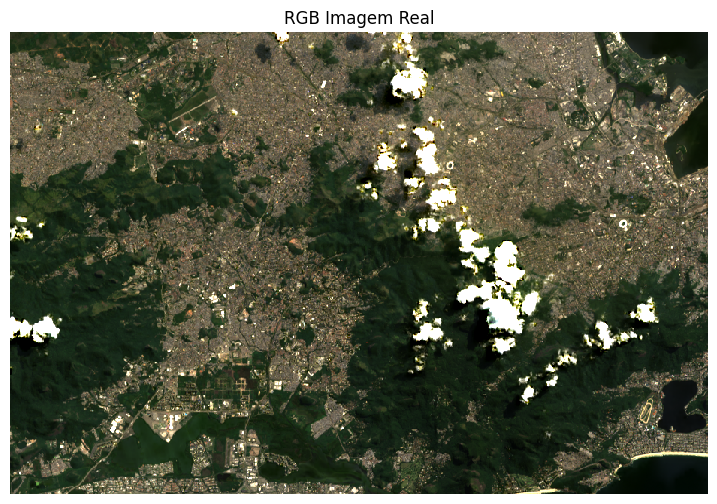

In [ ]:
# Plot  RGB 
fig, ax = plt.subplots(figsize=(9,6))
data1.isel(time=scene)[["red", "green", "blue"]].to_array().plot.imshow(robust=True, ax=ax, vmin=0.0, vmax=0.25)
ax.set_title("RGB Imagem Real")
ax.axis('off')
plt.show()

 O <b>Índice de Vegetação por Diferença Normalizada (NDVI)</b> é utilizado para medir a "verdejura" da vegetação e possui um intervalo de 0.0 a 1.0.
 Valores baixos (0.0 a 0.25) refletem a falta de vegetação (solo nu, áreas urbanas, água), valores intermediários (0.25 a 0.6) refletem pastagens ou terras agrícolas em estado de crescimento,
 e valores altos (0.6 a 1.0) refletem vegetação densa, como árvores ou terras agrícolas no auge de seu estado de vegetação.
 A equação usa duas bandas espectrais onde: <b>NDVI = (NIR - Vermelho) / (NIR + Vermelho)</b>


In [18]:
# Calculate NDVI for the median mosaic
ndvi_data = (data1.isel(time=scene).nir08-data1.isel(time=scene).red)/(data1.isel(time=scene).nir08+data1.isel(time=scene).red)

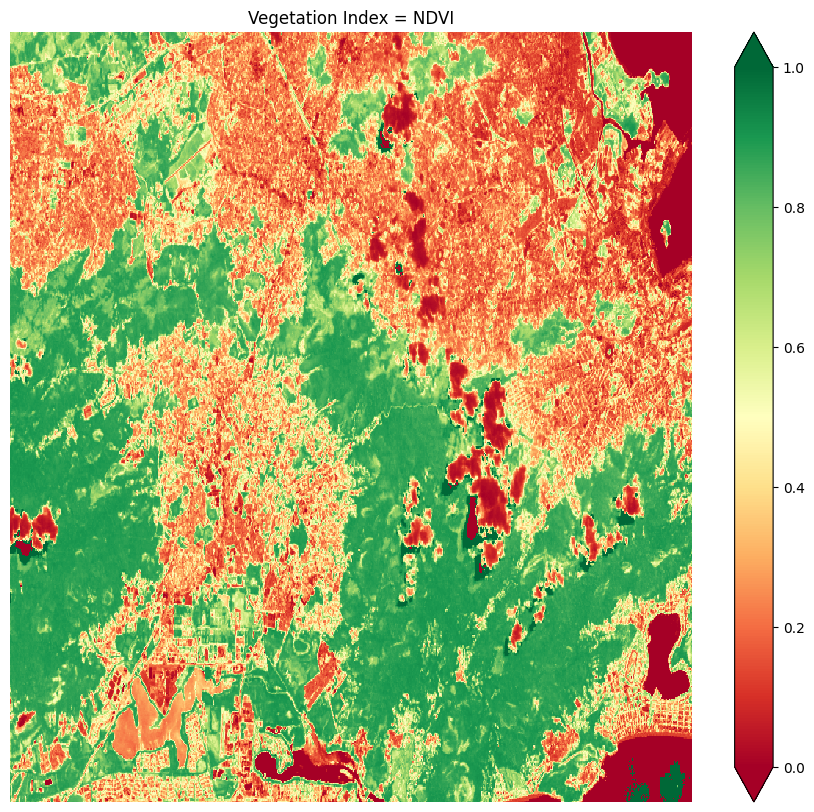

In [19]:
fig, ax = plt.subplots(figsize=(11,10))
ndvi_data.plot.imshow(vmin=0.0, vmax=1.0, cmap="RdYlGn")
plt.title("Vegetation Index = NDVI")
plt.axis('off')
plt.show()

### Landsat Surface Temperature

Agora sim verificando a nossa variavel Target

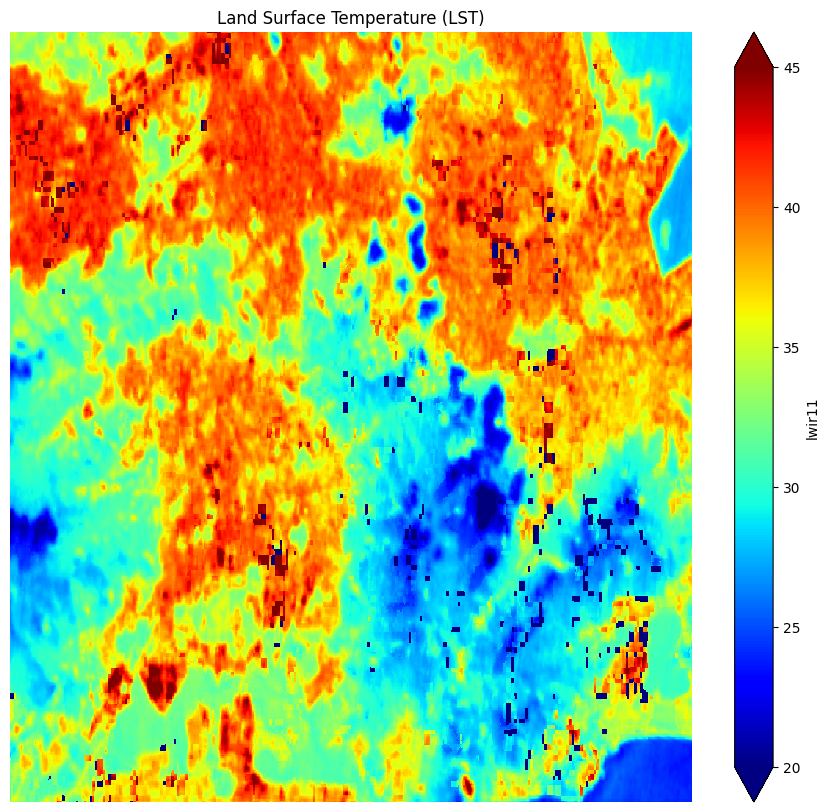

In [20]:
fig, ax = plt.subplots(figsize=(11,10))
data2.isel(time=scene).lwir11.plot.imshow(vmin=20.0, vmax=45.0, cmap="jet")
plt.title("Land Surface Temperature (LST)")
plt.axis('off')
plt.show()

### Salvando o output em um arquivo Geotiff
O processo foi repetido pra todos os recortes mencionados anteriormente

In [ ]:

data3 = data2.isel(time=scene)

In [22]:
filename = "Temp_recorte9.tiff"

In [ ]:
# Calcular a dimensao
height = data3.dims["latitude"]
width = data3.dims["longitude"]

In [ ]:
# Definindo o Sistema de Referência de Coordenadas (CRS) para as coordenadas comuns de Latitude-Longitude
# Defininndo a transformação usando nossos limites (bounding box) para que as informações de Lat-Lon sejam escritas no GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data3.rio.write_crs("epsg:4326", inplace=True)
data3.rio.write_transform(transform=gt, inplace=True);

In [ ]:
# Criando o arquivo de saída GeoTIFF usando os parâmetros definidos
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=1,compress='lzw',dtype='float64') as dst:
    dst.write(data3.lwir11,1)
    dst.close()

In [ ]:
# Mostrando os arquivos GeoTIFF criados
!ls *.tiff

S2_samplev.tiff     Temp_recorte4.tiff	Temp_recorte9.tiff  recorte5.tiff
S2_samplev3.tiff    Temp_recorte5.tiff	recorte1.tiff	    recorte6.tiff
Temp_recorte1.tiff  Temp_recorte6.tiff	recorte2.tiff	    recorte7.tiff
Temp_recorte2.tiff  Temp_recorte7.tiff	recorte3.tiff	    recorte8.tiff
Temp_recorte3.tiff  Temp_recorte8.tiff	recorte4.tiff	    recorte9.tiff
